In [1]:
'''
Function Description:使用预先训练好的网络VGG16分类猫狗
'''
from keras.applications import VGG16 #加载VGG16
conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary()


58892288/58889256 [==============================] - 65s 1us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________________________

In [6]:
import os
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
#加载训练图片和测试图片
base_dir = '/home/liangyi/workplace/python/MachineLearning/NeuralNetwork/cat-and-dog/'
train_dir = os.path.join(base_dir,'training_set')
train_cats_dir = os.path.join(base_dir, 'training_set/cats')
train_dogs_dir = os.path.join(base_dir, 'training_set/dogs')
test_dir = os.path.join(base_dir, 'test_set')
test_cats_dir = os.path.join(base_dir, 'test_set/cats')
test_dogs_dir = os.path.join(base_dir, 'test_set/dogs')
train_images_count = len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))
test_images_count = len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir))

In [12]:
print(train_images_count)
print(test_images_count)

8007
2025


In [38]:
#对VGG16进行封装方便使用
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def train_images_by_vgg16(directory, sample_count):
    #VGG的输出结果是（4，4，512）
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')
    i = 0
    #把猫狗的图片输入VGG16中，将图片信息提取出来
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        if (i+1)*batch_size <= sample_count:
            features[i*batch_size:(i+1)*batch_size] = features_batch
            labels[i*batch_size:(i+1)*batch_size] = labels_batch
        else:
            features[i*batch_size:i*batch_size+len(features_batch)] = features_batch
            labels[i*batch_size:i*batch_size+len(features_batch)] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            return features, labels
        print(i)

In [37]:
#将图片输入到VGG16中
train_features, train_labels = train_images_by_vgg16(train_dir, train_images_count)
test_features, test_labels = train_images_by_vgg16(test_dir, test_images_count)

Found 8005 images belonging to 2 classes.
1
2


KeyboardInterrupt: 

In [32]:
#将得到的图片features和labels用自己的CNN进行分类
from keras import layers
from keras import models
from keras import optimizers
#构造我们自己的分类网络
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim= (4*4*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
#compile the CNN
model.compile(optimizer=optimizers.RMSprop(lr = 2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(test_features, test_labels))

Epoch 1/30
81/81 [==============================] - 4s 38ms/step - loss: 0.6606 - acc: 0.6214 - val_loss: 0.3982 - val_acc: 0.8430
Epoch 2/30
81/81 [==============================] - 4s 45ms/step - loss: 0.4124 - acc: 0.8154 - val_loss: 0.3346 - val_acc: 0.8662
Epoch 3/30
81/81 [==============================] - 4s 45ms/step - loss: 0.3391 - acc: 0.8509 - val_loss: 0.3082 - val_acc: 0.8716
Epoch 4/30
81/81 [==============================] - 3s 39ms/step - loss: 0.3097 - acc: 0.8671 - val_loss: 0.2912 - val_acc: 0.8815
Epoch 5/30
81/81 [==============================] - 3s 39ms/step - loss: 0.2807 - acc: 0.8850 - val_loss: 0.2793 - val_acc: 0.8884
Epoch 6/30
81/81 [==============================] - 4s 44ms/step - loss: 0.2765 - acc: 0.8840 - val_loss: 0.2768 - val_acc: 0.8835
Epoch 7/30
81/81 [==============================] - 4s 46ms/step - loss: 0.2634 - acc: 0.8883 - val_loss: 0.2623 - val_acc: 0.8963
Epoch 8/30
81/81 [==============================] - 4s 44ms/step - loss: 0.2525 - a

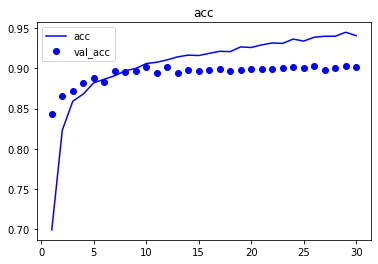

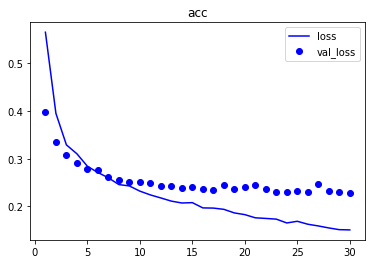

In [33]:
#展示acc和loss
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 1 + len(acc))
plt.plot(epochs, acc, 'b', label = 'acc')
plt.plot(epochs, val_acc, 'bo', label = 'val_acc')
plt.title('acc')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label = 'loss')
plt.plot(epochs, val_loss, 'bo', label = 'val_loss')
plt.title('acc')
plt.legend()
plt.show()